In [10]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as fun
import numpy as np
import pandas as pd

# Load do dataset

In [11]:
from lib.data import load_dataset

rs = 2

x_train, y_train, x_valid, y_valid = load_dataset('dts/dts_plain/train.csv',rs=rs)
x_test = load_dataset('dts/dts_plain/test.csv',test_only=True,rs=rs)

# Normalização

In [12]:
from sklearn.preprocessing import StandardScaler
from my_nn import dts

sc = StandardScaler()
sc.fit(x_train.values)

x_train = sc.transform(x_train.values)
x_valid = sc.transform(x_valid.values)
x_test = sc.transform(x_test.values)

# Feature Selection

In [14]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

selec_mod = SelectFromModel(estimator=LogisticRegression(random_state=rs, max_iter=2000)).fit(x_train, y_train)

x_train = selec_mod.transform(x_train)
x_valid = selec_mod.transform(x_valid)
x_test = selec_mod.transform(x_test)

# Dataloaders

In [15]:
from torch.utils.data import DataLoader
train_dts = dts(x_train,y_train)
valid_dts = dts(x_valid,y_valid)

training_loader = DataLoader(train_dts, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dts, batch_size=32, shuffle=True)

In [17]:
from my_nn import nnModel

model = nnModel(inFeatures = x_train.shape[1], random_state=2)

losses, accs = model.fit(
    trainloader=training_loader,
    validloader=valid_loader,
    learningRate=0.02,
    momentum=0.9,
    gamma=0.97,
    numEpochs=31,
    verbose=False
)

[394.0386022217572, 226.79664776846766, 169.40144319273531, 136.57306786812842, 116.63110551913269, 103.40455693751574, 92.96948285494, 81.2042411591392, 72.37687484221533, 65.7604257252533, 56.61868022457929, 50.68457840124756, 44.08693372446578, 41.90944343974115, 38.08720534112945, 31.590904894532287, 31.393206280550658, 29.907288265581883, 21.888162286115403, 19.257458874861186, 17.040818647546075, 14.81222272750938, 16.494777533404886, 8.09441336771215, 14.870415381844737, 12.970649281908209, 6.04443669887587, 4.742936336474941, 3.829802208541423, 3.6224334051984783, 3.4875595026976782]
[93.7625, 95.5, 95.95, 96.2125, 95.75, 96.6625]


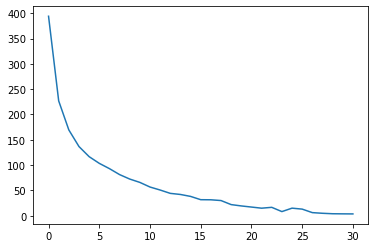

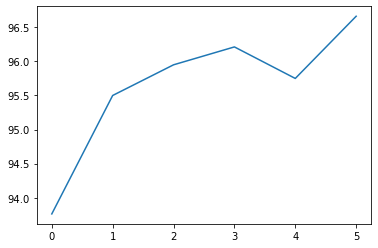

In [18]:
print(losses)
print(accs)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(losses)
plt.figure()
plt.plot(accs)

In [19]:
# model = model.to(torch.device('cpu'))

# tst = torch.tensor(x_test, dtype=torch.float32).to(torch.device('cuda'))

ypred = model.predict(torch.tensor(x_test, dtype=torch.float32))


In [20]:
import pandas as pd
result = pd.DataFrame(data={
        "Id": range(len(ypred)),
        "Category": ypred.astype(int)
    }, index=None)

result.to_csv("result.csv", index=None)